In [18]:
# %pip install graphviz
# %pip install pydot --upgrade
# %pip install pydotplus --upgrade

In [19]:
from pathlib import Path
import imghdr
import os

data_dir = "/hair_types"
image_extensions = [".png", ".jpg"] # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "hair_types",
 validation_split=0.1,
 subset="training",
 seed=1337,
 image_size=image_size,
 batch_size=batch_size,
 labels='inferred',
 label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "hair_types",
 validation_split=0.1,
 subset="validation",
 seed=1337,
 image_size=image_size,
 batch_size=batch_size,
 labels='inferred',
 label_mode='categorical'
)


Found 987 files belonging to 3 classes.
Using 889 files for training.
Using 889 files for training.
Found 987 files belonging to 3 classes.
Using 98 files for validation.


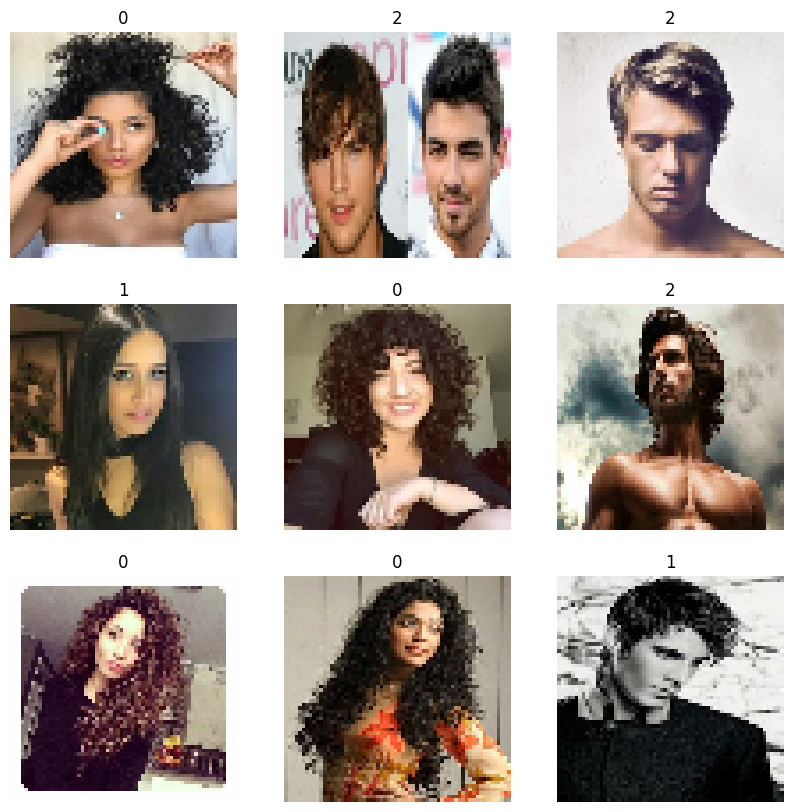

In [21]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
 for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(np.argmax(labels[i])))
    plt.axis("off")
plt.show()

In [22]:
from tensorflow import data as tf_data
# Configuring dataset for performance
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_ds.prefetch(tf_data.AUTOTUNE)
val_dataset = val_ds.prefetch(tf_data.AUTOTUNE)

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband
from tensorflow.keras.layers import SpatialDropout2D


# Define the model-building function

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=image_size + (3,)))
    model.add(layers.Rescaling(1.0 / 255))
    #model.add(layers.RandomFlip("horizontal"))
    #model.add(layers.RandomRotation(0.1))

    # Tune the number of filters and kernel size for each convolutional layer
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=3)): # Tune the number of convolutional layers
        model.add(layers.Conv2D(
            filters=hp.Int('filters_' + str(i), min_value=4, max_value=16, step=4), # Tune the number of filters
            kernel_size=hp.Choice('kernel_size_' + str(i), values=[4, 8, 16]), # Tune the kernel size
            strides=1,
            padding='valid',
            dilation_rate=1,
            kernel_regularizer=keras.regularizers.l2(hp.Choice('l2_reg', values=[0.0, 1e-3, 1e-4, 1e-5])) # Add L2 regularization
        ))
        model.add(layers.Activation("relu")) # Add ReLU activation function
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2)) # Add max pooling layer

    model.add(layers.GlobalAveragePooling2D()) # Add global average pooling layer

    # Add more layers for complexity
    for _ in range(hp.Int('num_dense_layers', min_value=1, max_value=3)): # Tune the number of dense layers
        model.add(layers.Dense(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

    model.add(layers.Dense(3, activation='softmax'))
    # Define the optimizer choices
    #optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

    # if optimizer_choice == 'adam':
    #     optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    # elif optimizer_choice == 'rmsprop':
    #     optimizer = keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    # elif optimizer_choice == 'sgd':
    #     optimizer = keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    # Compile the model with the specified optimizer
    model.compile(
        optimizer= keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


from datetime import datetime
import os

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a unique project name by appending the current date and time
project_name = f"hair_prediction_{current_time}"

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    directory='keras_tuner',
    project_name= 'hair_prediction_5'
)

# Perform the hyperparameter search
tuner.search(train_ds, epochs=20, validation_data=val_ds)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]



Reloading Tuner from keras_tuner\hair_prediction_5\tuner0.json


c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras_tuner\src\tuners\hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [24]:
# Assuming 'tuner' is your Keras Tuner object
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Create a table header
print(f"{'Parameter':<25} | {'Value'}")

# Separator for clarity
print("-" * 40)

# Iterate over the hyperparameters and print them
for hp_name in best_hyperparameters.values:
    print(f"{hp_name:<25} | {best_hyperparameters.get(hp_name)}")

Parameter                 | Value
----------------------------------------
num_conv_layers           | 3
filters_0                 | 16
kernel_size_0             | 16
l2_reg                    | 1e-05
num_dense_layers          | 1
units                     | 32
learning_rate             | 0.001
filters_1                 | 16
kernel_size_1             | 4
filters_2                 | 4
kernel_size_2             | 8
tuner/epochs              | 7
tuner/initial_epoch       | 3
tuner/bracket             | 2
tuner/round               | 1
tuner/trial_id            | 0008


In [25]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.models import Sequential
# from keras.layers import Dense


# model = Sequential()

# model.add(keras.Input(shape=image_size + (3,))) # 64, 64, 3
# model.add(layers.Rescaling(1.0 / 255))
# #model.add(layers.RandomFlip("horizontal"))
# #model.add(layers.RandomRotation(0.1))


# model.add(layers.Conv2D(filters=16, kernel_size=16, strides=1, padding='valid', dilation_rate=1, kernel_regularizer=keras.regularizers.l2(1e-5)))
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=1, kernel_regularizer=keras.regularizers.l2(1e-5)))
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# model.add(layers.Conv2D(filters=4, kernel_size=8, strides=1, padding='valid', dilation_rate=1, kernel_regularizer=keras.regularizers.l2(1e-5)))
# model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))
# model.add(layers.SpatialDropout2D(0.5))

# model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(32))
# model.add(layers.Activation("relu"))
# model.add(layers.Dense(3))
# model.add(layers.Activation("softmax"))

# #keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

# model.compile(
#  optimizer=keras.optimizers.Adam(1e-3),
#  loss="categorical_crossentropy",
#  metrics=["accuracy"],
# )



Epoch 1/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5384 - loss: 0.9612 - val_accuracy: 0.5612 - val_loss: 0.9145
Epoch 2/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5392 - loss: 0.9250 - val_accuracy: 0.5816 - val_loss: 0.8937
Epoch 3/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5810 - loss: 0.8704 - val_accuracy: 0.5306 - val_loss: 0.8995
Epoch 4/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5880 - loss: 0.8800 - val_accuracy: 0.5510 - val_loss: 0.8995
Epoch 5/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5876 - loss: 0.8835 - val_accuracy: 0.5612 - val_loss: 0.8576
Epoch 6/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5608 - loss: 0.8841 - val_accuracy: 0.6327 - val_loss: 0.8428
Epoch 7/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5765 - loss: 0.8959 - val_accuracy: 0.4796 - val_loss: 0.8805
Epoch 8/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6020 - loss: 0.8363 - val_accuracy: 0.5408 - v

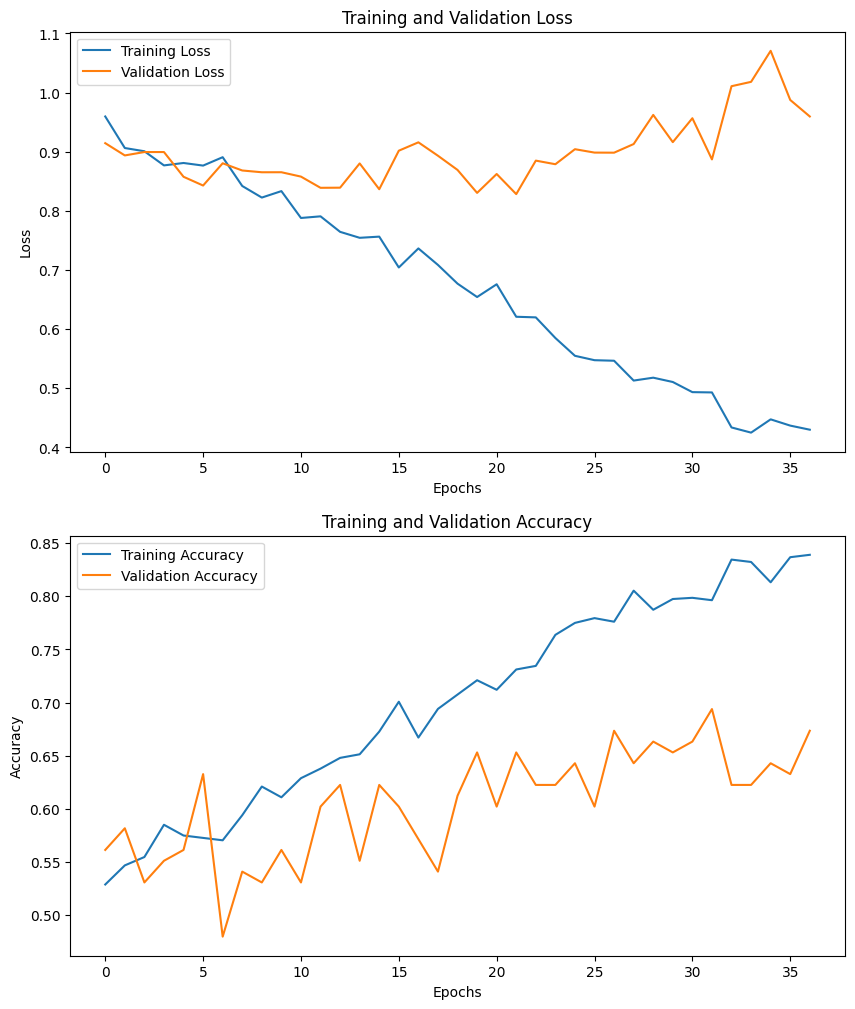

In [26]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

epochs = 75

# Assuming train_ds and val_ds are defined and the model is compiled
history = best_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[EarlyStopping(patience=15)])
#history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


# Creates a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2)

# Show the combined graph
plt.show()




In [27]:

# Evaluate the best model
totaltrain_accuracy = 0
totaltrain_loss = 0

num_iterations = 10



for _ in range(num_iterations):
    loss, accuracy = best_model.evaluate(train_ds)
    totaltrain_accuracy += accuracy
    totaltrain_loss += loss


average_accuracy = totaltrain_accuracy / num_iterations
average_loss = totaltrain_loss / num_iterations
print("Average Training Accuracy:", average_accuracy)
print("Average Training Loss:", average_loss)

totalval_accuracy = 0
totalval_loss = 0
for _ in range(num_iterations):
    loss, accuracy = best_model.evaluate(val_ds)
    totalval_accuracy += accuracy
    totalval_loss += loss


average_accuracy = totalval_accuracy / num_iterations
average_loss = totalval_loss / num_iterations
print("Average Validation Accuracy:", average_accuracy)
print("Average Validation Loss:", average_loss)





28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8603 - loss: 0.3671
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8349 - loss: 0.4104
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8505 - loss: 0.3963
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8504 - loss: 0.3814
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8465 - loss: 0.3899
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8470 - loss: 0.3990
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8546 - loss: 0.3750
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8473 - loss: 0.3967
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8329 - loss: 0.4161
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8436 - loss: 0.4008
Average Training Accuracy: 0.848143994808197
Average Training Loss: 0.3970115274190903
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6923 - loss: 0.9141  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6465 - loss: 1.0604  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

In [28]:
img = keras.preprocessing.image.load_img(
"8126fdb0-ab66-4c49-a85c-f100bc12966a.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis
predictions = model.predict(img_array)
print(
 "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
 % tuple(predictions[0])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This image is 0.78 percent curly hair, 0.21 percent straight hair, and 0.01 percent wavy hair.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This image is 0.78 percent curly hair, 0.21 percent straight hair, and 0.01 percent wavy hair.
